## Relax Take Home Assignment

In [1]:
# Import baseline packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import Engagement Data
raw_df = pd.read_csv('takehome_user_engagement.csv')

In [3]:
#Check Dataframe
raw_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
#Examine contents - see that "visited" is a relic
raw_df.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
# Check Time Stamp feature as it appears to be a string
type(raw_df['time_stamp'][0])

str

In [7]:
#Verify the data is sorted by user_id and then time_stamp
raw_df_sorted = raw_df.sort_values(['user_id','time_stamp'])

In [8]:
raw_df_sorted

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


Alright, so we need to create a flag for each user that is an "adopted_user" or not based on whether they logged into the product on three seperate days in at least one seven-day period. We can use the structure of the Data Frame to help us develop an algorithm to work through the task

"adopted_user" definition is as a user who has logged into the product on three separate days in at least one seven day period.

Auto-exclude criteria
* If a user has less than 3 logins

Auto-include criteria
* If a user's max time - min time is less than 7 days and has 3 logins

After that need to work through table

In [9]:
#Let's create a holder table for the results
results_df = pd.DataFrame({'user_id':raw_df_sorted['user_id'].unique(),'adopted_user':-1})
results_df

,user_id,adopted_user
0,1,-1
1,2,-1
2,3,-1
3,4,-1
4,5,-1
...,...,...
8818,11996,-1
8819,11997,-1
8820,11998,-1
8821,11999,-1


In [10]:
#First let's gather our users by login
login_counts = raw_df_sorted[['user_id','visited']].groupby('user_id').count()

In [11]:
#Second, make a list of users who have less than 3 visits
login_counts_excludes = login_counts.loc[login_counts['visited'] < 3]

In [12]:
#Third, let's make a list of the users lacking enough logins
exclude_list = list(login_counts_excludes.index)

In [13]:
#Fourth, let's associated any user_id on the exclude_list with a value of "0"
results_df['adopted_user'] = results_df['user_id'].apply(lambda x: 0 if x in exclude_list else -1)

In [14]:
#Fifth, let's check the result
results_df['adopted_user'].value_counts()

 0    6575
-1    2248
Name: adopted_user, dtype: int64

So off the bat, we can see that the vast majority of our users would not be considered "adopted" users. This is useful to know because we can garner that as a population, it will be heavily weighted towards "negative" results as opposed to "positive results."

In order to check the remaining users, we'll need to work with our data a little bit to get the date and time features ready for easier processing

In [15]:
#Let's get the date and time features of our observations so we can more easily process time deltas
raw_df_sorted['iso_date'] = raw_df_sorted['time_stamp'].str[0:10]

In [16]:
#Let's make it a datetime object
raw_df_sorted['datetime_obj'] = pd.to_datetime(raw_df_sorted['iso_date'], format='%Y-%m-%d')

In [17]:
#Let's pair it down strictly to dates for now to faciliate easy processing
raw_df_sorted['date_obj'] = raw_df_sorted['datetime_obj'].dt.date

One way we can make processing easier for us is to simply make a table of "possible adopted_users" to work through with an algorithm

In [18]:
#Let's make a new DataFrame of just possible adopted users for easier processing
possible_adopted_user_df = raw_df_sorted[~raw_df_sorted['user_id'].isin(exclude_list)]

In [19]:
#Now let's make a list of all the possible user_ids we have to work through
possible_list = list(possible_adopted_user_df['user_id'].unique())

The algorithm we need to create will do the following:
* It will pull out a specific user's logins
* Will check to see if they meet the relative criteria
* Return a list of users who meet the critiera

In [20]:
#Let's create our algorithm which works under the assumption that the table is sorted by user id and then login
adopted_user_list = []
for user_id in possible_list:
    check_df = possible_adopted_user_df.loc[possible_adopted_user_df['user_id'] == user_id] #Creates user specific table
    check_df_len = len(check_df) #Get the length of the table so we know when we are done and then the last possible row index we can check (since after that index, there are only 2 observations)
    #print(f' {check_df_len} with {user_id}')
    for counter in range(0,check_df_len - 2): #We subtract 2 (1 value since len adds one natural and another 1 since we need to cut short by an additional index number)
        startdate = check_df.iloc[counter, 5]
        middate = check_df.iloc[counter + 1, 5]
        enddate = check_df.iloc[counter + 2, 5]
        datelist = [startdate, middate, enddate]
        holderdelta = enddate - startdate #Checks that we are at least within a week
        flag = len(set(datelist)) == len(datelist) #Checks that it is 3 unique dates
        #print(flag)
        if (holderdelta.days <= 7 and flag):
            adopted_user_list.append(user_id)
            break

In [21]:
#Now let's update our results DataFrame to account for who is an adopted user and label everyone else a non-adopted users
results_df['adopted_user'] = results_df['user_id'].apply(lambda x: 1 if x in adopted_user_list else 0)

In [22]:
results_df.head()

,user_id,adopted_user
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [23]:
results_df['adopted_user'].value_counts()

0    7167
1    1656
Name: adopted_user, dtype: int64

This allows us to now accurately consider who is an adopted user in our data set and who is not an adopted user in our dataset based on usage. We can now import the user information table

In [24]:
#Import user information table
user_info = pd.read_csv('takehome_users.csv', encoding = 'ISO-8859-1')

In [25]:
#Check Resulting Table
user_info.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


Based on the documentation, we see that 'object_id' is the user_id with the other table, which means we can use it to join our tables together. Let's convert the name so it lines up.

In [26]:
#Rename Column
user_info.rename(columns={'object_id':'user_id'},inplace = True)

We will work under the assumption that if a user is not in the __engagement__ table, then we can safely assume they are not an "adopted_user." This means the amount of "negatives" (aka not an adopted users) will be even higher than the results table would have indicated when we were processing it

In [27]:
# Use a left join on the user_info table
user_info_df = user_info.join(results_df, on='user_id', how='left', lsuffix ='l', rsuffix='r')

In [28]:
user_info_df.head()

,user_idl,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_idr,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,3.0,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,4.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,5.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,6.0,0.0


In [29]:
#Let's clean up the resulting DataFrame
user_info_df.drop(['user_idr'], axis= 1, inplace=True) #Drop duplicated user id from results table
user_info_df.rename(columns={'user_idl':'user_id'},inplace = True) #Rename the user_id name to be more clear

In [30]:
user_info_df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [31]:
#Last, let's fill in the NaN values for the adopted_user to be zero since they cannot be adopted_users
user_info_df.adopted_user.fillna(0,inplace=True)

In [32]:
#Let's take a first look at our nearly complete data set
user_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted_user                12000 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.0+ MB


We can see that two features need to be considered due to null values, 'last_session_creation_time' and 'invited_by_user_id'. Another issue is that our 'adopted_user' feature is now a float when it would be better as an integer, which can also be said about invited_by_user. We see that last_session_creation_time is a float64 and from the documentation, it is the unix timestamp of last login.

In [33]:
#Let's convert the 'adopted_user' to an integer
user_info_df['adopted_user'] = user_info_df['adopted_user'].astype(int)

In [34]:
#Let's get a sense of the invite_by_user_id feature in terms of spread
user_info_df['invited_by_user_id'].value_counts()

10741.0    13
2527.0     12
1525.0     11
11770.0    11
2308.0     11
           ..
1390.0      1
5445.0      1
8526.0      1
4695.0      1
5450.0      1
Name: invited_by_user_id, Length: 2564, dtype: int64

We can see that most 'repeated' user has only 13 observations. This would imply that we would be better off creating a new binary feature that was simply "invited by another user" once we are done looking through this data. Another thing to consider is if there is any colinearity that could be associated with the 'creation_source. First, let's fill in the null values with 0 since no user has a value of 0 and then create our feature.

In [35]:
#Fill in null values
user_info_df['invited_by_user_id'].fillna(0, inplace=True)

In [36]:
user_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  float64
 10  adopted_user                12000 non-null  int32  
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 984.5+ KB


The last feature to consider is the 'last_session_creation_time' which is a unix timestamp. Given that it will be pretty tough to actually learn anything based on a specific date, it will most likely make sense to simply consider whether they have created at least one session. This also correlates with our results table as we have 8823 observations in there so anyone who has a null value is someone who has basically never created a session.

In [37]:
#Fill in mising values for last session creation
user_info_df['last_session_creation_time'].fillna(0, inplace=True)

In [38]:
user_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  float64
 10  adopted_user                12000 non-null  int32  
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 984.5+ KB


With our dataset no long having any sparse values, we can begin to do some EDA and Feature Engineering to prepare it for modeling. That said, let's look at the features from a macro level to consider which ones make sense to consider for modeling:
* user_id: Is simply the unique identifier for a user and therefore wouldn't be useful for modeling purpose but is useful for identifying a specific data observation
* creation_time: Is when a user creates their ID. From a business sense, this wouldn't be something you could functionally act upon so we wouldn't include it in our modeling data
* name: same reasoning as creation_time, you cannot act upon it
* email: same reasoning as creation_time, you cannot act upon it
* creation_source: Provides 5 possible alternatives on how a user signed up. This may be a useful categorical feature to consider for modeling
* last_session_creation_time: Overlaps with our engagement table. That said, we can convert this into a binary feature of 'created_session'
* opted_in_to_mailing_list: Another potential easy to use binary feature for modeling purposes
* enabled_for_marketing_drip: Another potential easy to use binary feature for modeling purposes
* org_id: Look below but there are quite a few organization with a substantial amount of users. As such, this may be a feature worth expanding into multiple dummy features to capture if org_id has predictive power (as our business may want to specifically target certain organization with a high rate of adopted users)
* invited_by_user_id: Since this feature is potentially not dense enough per user to be informative, we could simply create a dummy variable where it simply captures if the user was invited by someone else.
* adopted_user: Is our 'outcome' feature we are measuring against, which means we are doing a version of supervised learning with a binary classifier

Let's act upon this informaiton to create a workable dataset for us to leverage for EDA and Modeling purposes

In [39]:
#First, let's create a binary feature for 'last_session_creation_time'
user_info_df['session_created'] = user_info_df['last_session_creation_time'].apply(lambda x: 1 if x != 0 else 0)

In [40]:
#Second, let's do the invited feature
user_info_df['invited'] = user_info_df['invited_by_user_id'].apply(lambda x: 1 if x > 0 else 0)

In [41]:
# Third-1, let's get some dummies for creation_source
user_info_df_dummies = pd.get_dummies(user_info_df, prefix ='c_source', columns =['creation_source'],dtype=int)

In [42]:
#Third-2, we'll drop the "SIGNUP" group and make that the baseline group (since it is the most simply group)
user_info_df_dummies.drop(['c_source_SIGNUP'], axis=1, inplace=True)

In [43]:
#Third-3, re-attach the 'creation-source' so we have the labels for reference
user_info_df_dummies['creation_source'] = user_info_df['creation_source']

In [44]:
# Fourth-1, let's make the dummy features for the org_ID's but this requires us to be a bit more careful
# Initially though, let's get a unique list of org_id's and value_counts to know what to drop
user_info_df['org_id'].unique()

array([ 11,   1,  94, 193, 197,  37,  74, 302, 318,  69, 130, 254,   0,
       175, 211,   2,  58,  54,   7,   6, 123,  81,  56, 134,  92, 251,
       283,  98, 401,  33,  59, 109, 276, 208, 332,  64, 235,  63,  14,
         4, 127,  32, 224, 304,  61,  51, 229,  88, 325, 150, 347, 203,
        21, 409, 215, 141,   5, 107, 184, 310, 367, 389,  89, 242,  68,
        16,  49, 185,  91, 172,   8,  43, 249,  26, 139,  70,  10, 252,
        53, 119,   3, 196, 335, 375, 303, 307,  25, 370,  83,  27, 306,
       118, 295,  19, 301, 100, 112, 263,  39,  12,  86, 402,  42, 103,
       373, 268,  30, 406,  48, 313,   9, 138, 261,  35, 264,  95,  55,
        60, 234,  28, 410, 170, 374,  15,  17, 364,  62, 244, 342, 225,
       121, 255, 411, 217, 165, 415, 104, 329, 278, 116, 151, 290, 200,
       187, 122, 353, 135, 328,  36,  13, 341, 349, 198, 153, 108,  77,
       142, 275, 176,  87, 191, 102, 245, 154, 218, 385,  76, 321, 159,
       371,  50,  75, 333, 137, 292, 286, 131, 178, 213, 376, 36

In [45]:
user_info_df['org_id'].value_counts()

0      319
1      233
2      201
3      168
4      159
      ... 
396      9
397      8
400      8
386      7
416      2
Name: org_id, Length: 417, dtype: int64

In [46]:
# It looks like '0' probably makes the most sense to drop as that would imply no associated organization
# Let's now create the dummies
user_info_df_dummies = pd.get_dummies(user_info_df, prefix ='orgid', columns =['org_id'],dtype=int)

In [47]:
user_info_df_dummies.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,adopted_user,...,orgid_407,orgid_408,orgid_409,orgid_410,orgid_411,orgid_412,orgid_413,orgid_414,orgid_415,orgid_416
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,10803.0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,316.0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,1525.0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,5151.0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,5240.0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
#Let's drop the '0' org_id identifier to make it the base
user_info_df_dummies.drop(['orgid_0'],axis=1,inplace=True)

In [49]:
#Finally, reattach the 'org_id' column so we have it for reference purposes
user_info_df_dummies['org_id'] = user_info_df['org_id']

In [50]:
user_info_df_dummies.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,adopted_user,...,orgid_408,orgid_409,orgid_410,orgid_411,orgid_412,orgid_413,orgid_414,orgid_415,orgid_416,org_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,10803.0,1,...,0,0,0,0,0,0,0,0,0,11
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,316.0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,1525.0,0,...,0,0,0,0,0,0,0,0,0,94
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,5151.0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,5240.0,0,...,0,0,0,0,0,0,0,0,0,193


Now that we have a fully-featured dataset, we can do some preliminary EDA to get a sense of which features may be best suited to helping us make predictions. It's important to remember that our outcome feature (adopted_user) is a binary classifier so our EDA should be representative of that as well.

In [51]:
#Let's check the creation source versus the amount of adopted users
EDA_creation_source_vs_adopted_user = user_info_df_dummies[['creation_source','adopted_user']].groupby('creation_source').count()
EDA_creation_source_vs_adopted_user.rename(columns={'adopted_user':'total_users'}, inplace=True)

In [52]:
holder = user_info_df_dummies[['creation_source','adopted_user']].groupby('creation_source').sum()

In [53]:
#Combine the information
EDA_creation_source_vs_adopted_user['adopted_users'] = holder['adopted_user']

In [54]:
#Get percentages
EDA_creation_source_vs_adopted_user['pct_adopted'] = EDA_creation_source_vs_adopted_user['adopted_users'] / EDA_creation_source_vs_adopted_user['total_users']

In [55]:
EDA_creation_source_vs_adopted_user.head()

,total_users,adopted_users,pct_adopted
creation_source,,,
GUEST_INVITE,2163,295,0.136385
ORG_INVITE,4254,592,0.139163
PERSONAL_PROJECTS,2111,299,0.141639
SIGNUP,2087,284,0.136080
SIGNUP_GOOGLE_AUTH,1385,186,0.134296


At a cursory glance, it would appear that the creation source of an account probably doesn't have much predictive power as the percentage breakdown would imply that it's fairly uniform. It may still be statistically significant but that doesn't necessarily mean substantial.

Let's check whether opting into the mailing list has some possible significance

In [56]:
EDA_mailing_list_versus_adopted_user = user_info_df_dummies[['opted_in_to_mailing_list','adopted_user']].groupby('opted_in_to_mailing_list').count()
EDA_mailing_list_versus_adopted_user.rename(columns={'adopted_user':'total_users'}, inplace=True)
holder = user_info_df_dummies[['opted_in_to_mailing_list','adopted_user']].groupby('opted_in_to_mailing_list').sum()
EDA_mailing_list_versus_adopted_user['adopted_users'] = holder['adopted_user']
EDA_mailing_list_versus_adopted_user['pct_adopted'] = EDA_mailing_list_versus_adopted_user['adopted_users'] / EDA_mailing_list_versus_adopted_user['total_users']
EDA_mailing_list_versus_adopted_user.head()

,total_users,adopted_users,pct_adopted
opted_in_to_mailing_list,,,
0,9006,1237,0.137353
1,2994,419,0.139947


It would also appear that opting into the mailing list isn't going to have much predictive power based on the percentages.

Let's check the marketing drip as well.

In [57]:
EDA_marketing_drip_versus_adopted_user = user_info_df_dummies[['enabled_for_marketing_drip','adopted_user']].groupby('enabled_for_marketing_drip').count()
EDA_marketing_drip_versus_adopted_user.rename(columns={'adopted_user':'total_users'}, inplace=True)
holder = user_info_df_dummies[['enabled_for_marketing_drip','adopted_user']].groupby('enabled_for_marketing_drip').sum()
EDA_marketing_drip_versus_adopted_user['adopted_users'] = holder['adopted_user']
EDA_marketing_drip_versus_adopted_user['pct_adopted'] = EDA_marketing_drip_versus_adopted_user['adopted_users'] / EDA_marketing_drip_versus_adopted_user['total_users']
EDA_marketing_drip_versus_adopted_user.head()

,total_users,adopted_users,pct_adopted
enabled_for_marketing_drip,,,
0,10208,1403,0.137441
1,1792,253,0.141183


We do see some greater difference than before but not much. This may fall into the category of statistically significant but not necessarily substantial

Let's see if being invited by a user makes a significant difference

In [58]:
EDA_invited_versus_adopted_user = user_info_df_dummies[['invited','adopted_user']].groupby('invited').count()
EDA_invited_versus_adopted_user.rename(columns={'adopted_user':'total_users'}, inplace=True)
holder = user_info_df_dummies[['invited','adopted_user']].groupby('invited').sum()
EDA_invited_versus_adopted_user['adopted_users'] = holder['adopted_user']
EDA_invited_versus_adopted_user['pct_adopted'] = EDA_invited_versus_adopted_user['adopted_users'] / EDA_invited_versus_adopted_user['total_users']
EDA_invited_versus_adopted_user.head()

,total_users,adopted_users,pct_adopted
invited,,,
0,5583,769,0.137740
1,6417,887,0.138227


Once again it would apear that being invited by someone versus not being invited has little predictive power. We can assume that simply creating a session will have some predictive power simply because it is a core requirement of being flagged as an 'adopted_user' so we shouldn't be surprised if it ends up being one of the stronger predictors.

Since the 'org_id' feature is broken into many dummy variables, it will be tough to really explore that but at a cursory level, it would appear that the features provided by the user id are actually not quite predictive in determining whether someone will be an 'adopted_user.' That said, the predictive power of a model may be more expansive if we include all these features together. Therefore, let's move to modeling. As a note - since all of our features are effectively binary features of 0 or 1, they are effectively pre-processed.

#### Modeling

Since we are working with a binary classifier, we should use models that fit this purpose. To begin with, let's get a baseline of "dummy" guessing

#### Binary Classifier Baseline - Naive Guess

In [59]:
#Baseline guessing value
print(user_info_df_dummies['adopted_user'].sum()/user_info_df_dummies['adopted_user'].count())

0.138


This number informs of us two important things. First, it implies that if we were to simply "default" to labeling everyone as a negative regarding "adopted_user" (meaning they are not an adopted_user), we would technically be correct 86.2% of the time (1 - 0.138). Thus, this means that if end up adopting a model, we use would need the model to provide a fairly high accuracy value for us to consider it a "worthwhile" model to base results on. It also would imply that we may to consider our "false negative" rate. Second, it informs us that the pool is fairly low for "positive" adopted users so we will definitely want to consider stratifying our data along the 'adopted_user' feature to verify that our training and testing sets have adequate representation.

In [60]:
#First, let's create our 'predictor features' and our 'outcome feature'
y = user_info_df_dummies['adopted_user']
X = user_info_df_dummies.drop(['user_id','creation_time','name',
                               'email','creation_source','last_session_creation_time','org_id',
                               'invited_by_user_id','adopted_user'],axis=1) #it's easier to drop the features we won't use than list all the ones we will

In [61]:
# Import relevant packages for test train split
from sklearn.model_selection import train_test_split

In [62]:
# Let's create our training and testing sets to evaluate predictive power. We'll use a testing size of 30% and set a random
#seed for reproducability. Test_train_split automatically also stratifies which should account for our low pool of
#adopted users
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

#### Binary Classifier 1 - Logistic Regression
Logistic Regression provides a good "initial" model to consider regarding performance and predictive power

In [63]:
# Import relevant pacakges (we'll include some more packages that will help with optimization as well)
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [64]:
# Let's create a GridSearchCV to determine our regularization parameter of C
Cs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
params = {'C':Cs}

#Instantiate our Logsistic Regression Object
logModel = LogisticRegression()

#Conduct GridSearch
logModel_opt = GridSearchCV(logModel, params)
logModel_opt.fit(X_train,y_train)
logModel_best = logModel_opt.best_estimator_

#Display the best params
f'The best C parameter is: {logModel_opt.best_params_}'

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

"The best C parameter is: {'C': 5}"

Given that we are getting warnings about the inability of the logistic model to converge, it would imply that it is not a model well suited to this dataset as it currently stands. Therefore, we'll move onto a RandomForestClassifier which is typically the standard model used in many settings

#### Binary Classifier 2 - Random Forest Classifier
Random Forest Classifier provides a good robust model to consider regarding performance and predictive power as it frequently the "best" model in many contexts

In [65]:
#import relevant packages
from sklearn.ensemble import RandomForestClassifier

In [66]:
#Setup ranges for GridSearchCV to check
n_ests = list(range(50,150))
max_dep = list(range(2,5))
params = {'n_estimators':n_ests,'max_depth':max_dep}


#Instantiate RFC
rfc = RandomForestClassifier()

#Check RFC models
rfc_opt = GridSearchCV(rfc,params)
rfc_opt.fit(X_train,y_train)
rfc_best = rfc_opt.best_estimator_

#Display the best params
f'The best parameters are: {rfc_opt.best_params_}'

"The best parameters are: {'max_depth': 2, 'n_estimators': 50}"

In [67]:
rfc_best.fit(X_train,y_train)

RandomForestClassifier(max_depth=2, n_estimators=50)

In [68]:
#Now let's score our best RFC model
rfc_best.score(X_test,y_test)

0.8661111111111112

We are at least getting a score of 86.6% which is good *but* isn't much better than our "naive" classifer. However, let's check our precision and recall score as well.

In [69]:
#import relevant packages
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [70]:
rfcPrecisionScore = precision_score(y_test,rfc_best.predict(X_test))
print(f' Random Forest Precision Score: {rfcPrecisionScore}')
rfcRecallScore = recall_score(y_test,rfc_best.predict(X_test))
print(f' Random Forest Recall Score: {rfcRecallScore}')

 Random Forest Precision Score: 0.0
 Random Forest Recall Score: 0.0


C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Due to the nature of our results, we can't really calculate either score effecitively which makes sense given how lop-sided our values were. In this case however, let's get a sense of importance regarding our features

In [71]:
feature_imp = pd.Series(rfc_best.feature_importances_, index = X.columns).sort_values(ascending=False)
feature_imp

orgid_176                     0.069643
orgid_234                     0.059595
opted_in_to_mailing_list      0.053101
orgid_171                     0.049175
enabled_for_marketing_drip    0.033422
                                ...   
orgid_160                     0.000000
orgid_159                     0.000000
orgid_158                     0.000000
orgid_157                     0.000000
orgid_416                     0.000000
Length: 420, dtype: float64

In [72]:
#Let's take the first 10 features to see if there is anything discernable from the first 15 values
feature_imp_CLEANED = feature_imp[0:15]
feature_imp_CLEANED

orgid_176                     0.069643
orgid_234                     0.059595
opted_in_to_mailing_list      0.053101
orgid_171                     0.049175
enabled_for_marketing_drip    0.033422
orgid_17                      0.033176
orgid_102                     0.028769
orgid_267                     0.028751
invited                       0.026657
orgid_270                     0.024827
session_created               0.020829
orgid_23                      0.019933
orgid_206                     0.018281
orgid_140                     0.017767
orgid_162                     0.017294
dtype: float64

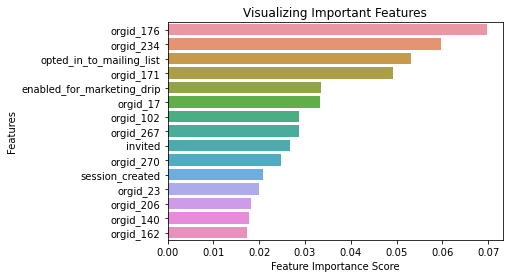

In [73]:
#Let's make a visualization of these result
sns.barplot(x=feature_imp_CLEANED, y=feature_imp_CLEANED.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

From the visualization, we can see most of our 'engineered' features not related to org_id (e.g., session_created, enabled_for_marketing_drip, opted_into_mailing_list, invited) rank among the top 15 features when it comes to predicting an adopted_user which is a good sign in general. That said, given that most of the features have a relatively low score, it would be an indication that none of the features are particularly powerful. That said, it may behove the organizaiton to reach out to some of the organizations in the higher importances (orgs 176, 102, 23, 113, etc.) and see if they work with them to get more adopted users since the Orgization did appear to have some predictive power.

Alright - from here we'll do our executive summary! Thank you for opportunity to complete this take home!